In [1]:
import numpy as np 
import pandas as pd
import matplotlib as mpl 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 
import math 
from xgboost import XGBClassifier, plot_importance 
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split 

from sklearn.impute import SimpleImputer 


In [2]:
import xgboost as xgb
from numpy import interp

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from termcolor import colored



In [3]:
import warnings
warnings.filterwarnings('ignore')


In [4]:
df_all = pd.read_excel('dataset.xlsx')

In [5]:
df_all.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA for Age

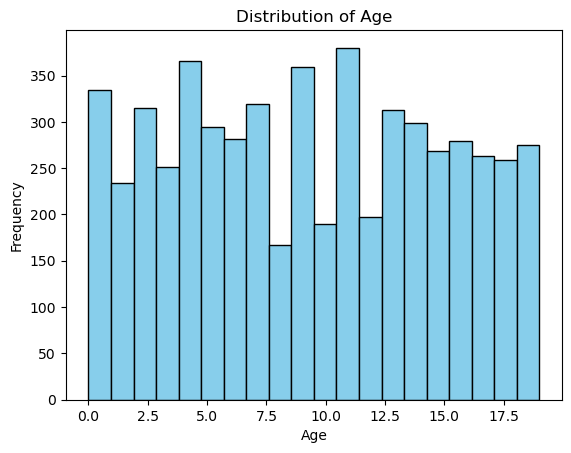

In [6]:
plt.hist(df_all['Patient age quantile'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


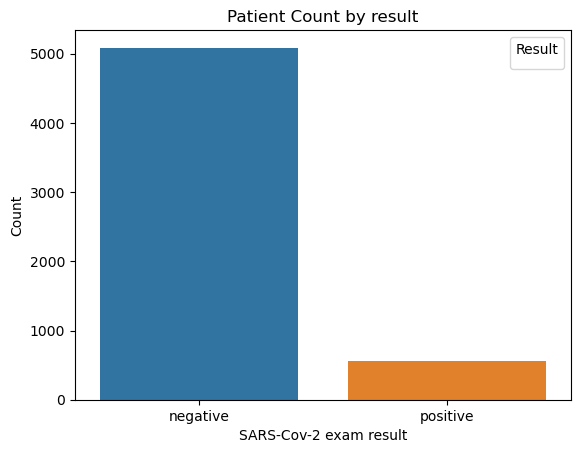

In [7]:
sns.countplot(x='SARS-Cov-2 exam result', data=df_all)
plt.xlabel('SARS-Cov-2 exam result')
plt.ylabel('Count')
plt.title('Patient Count by result')
plt.legend(title='Result', loc='upper right')
plt.show()

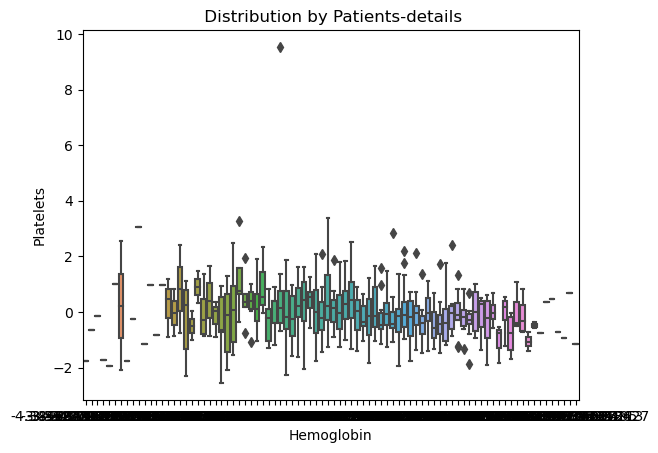

In [8]:
sns.boxplot(x='Hemoglobin', y='Platelets', data=df_all)
plt.xlabel('Hemoglobin')
plt.ylabel('Platelets')
plt.title(' Distribution by Patients-details')
plt.show()

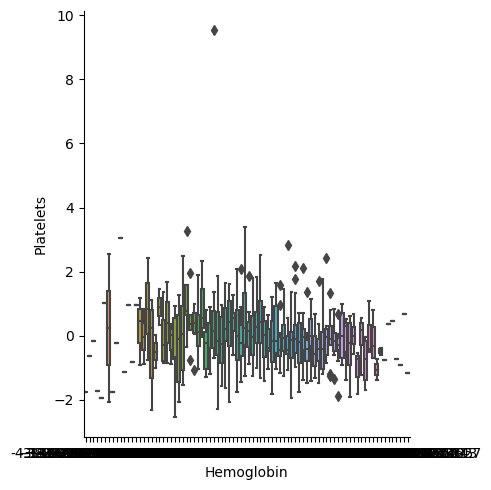

In [9]:
sns.catplot(data=df_all, x="Hemoglobin", y="Platelets", kind='box')
plt.show()

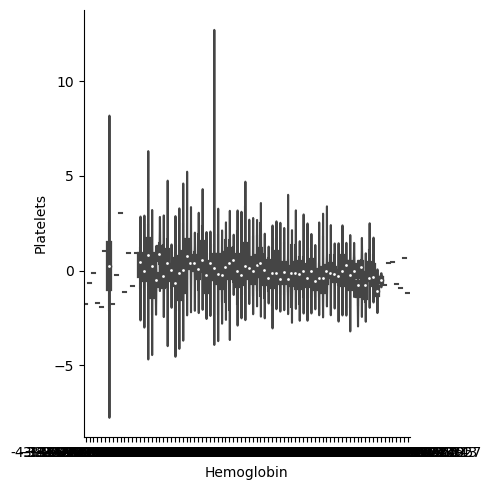

In [10]:
sns.catplot(data=df_all, x="Hemoglobin", y="Platelets", kind='violin',split=True)
plt.show()

In [11]:
print("The dataset has {} rows and {} columns".format(df_all.shape[0], df_all.shape[1]))

The dataset has 5644 rows and 111 columns


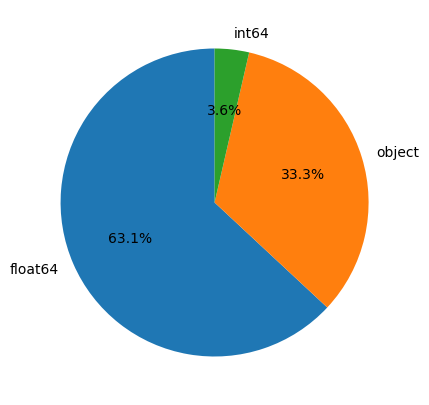

In [12]:
plt.figure(figsize=(5,5))
df_all.dtypes.value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.show()

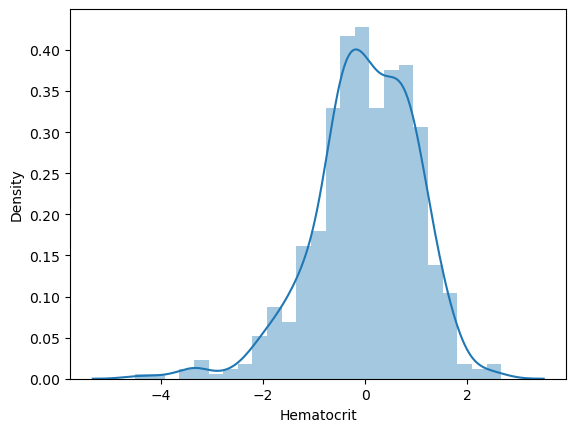

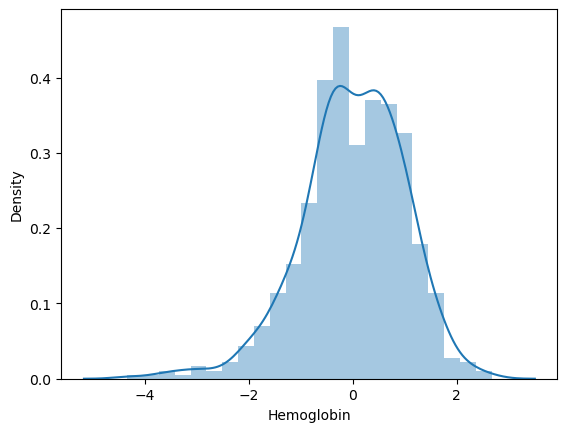

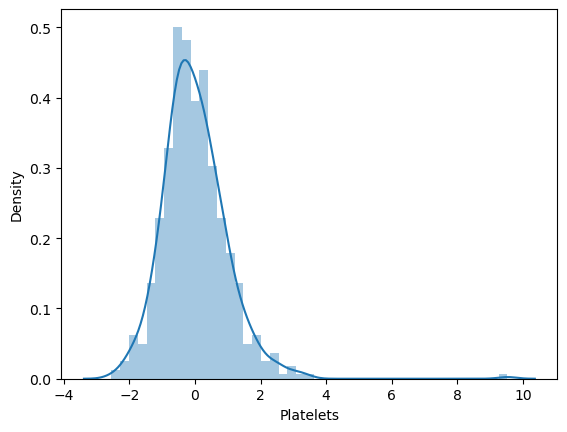

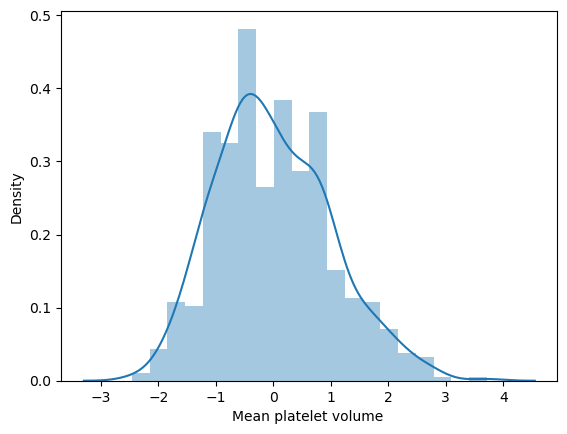

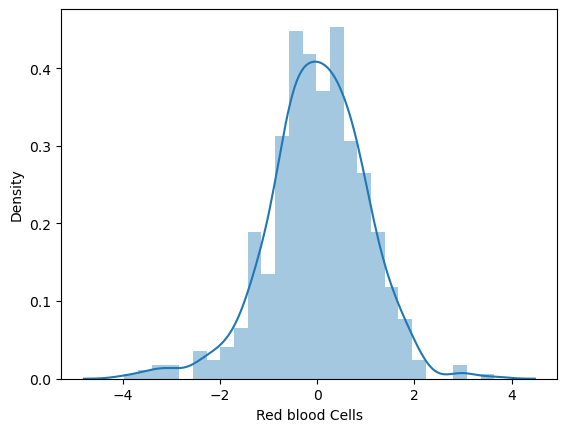

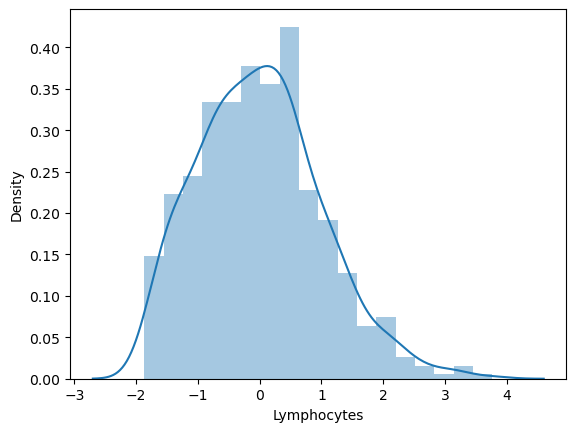

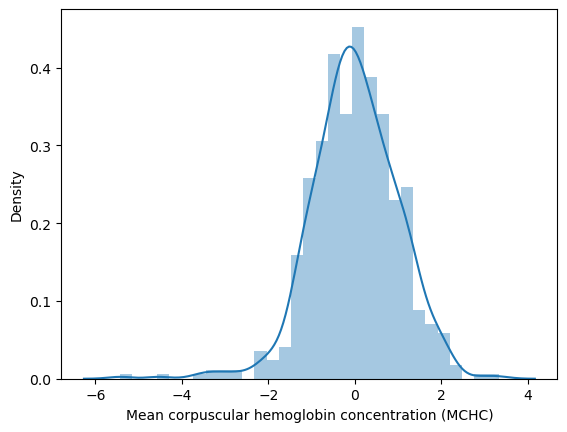

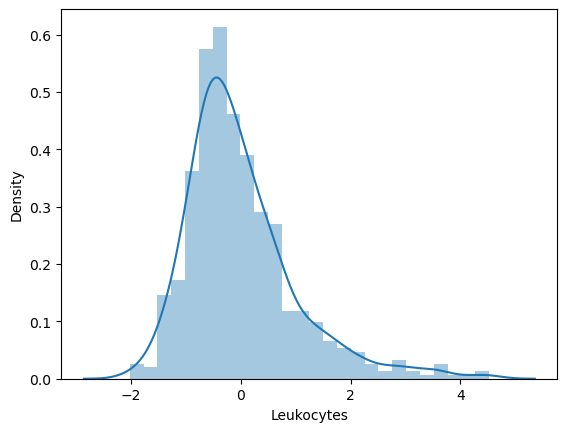

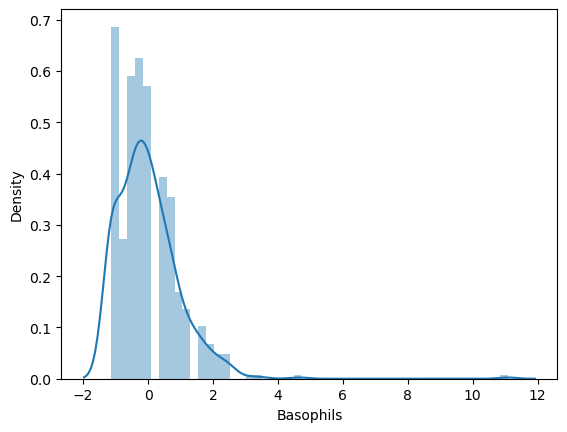

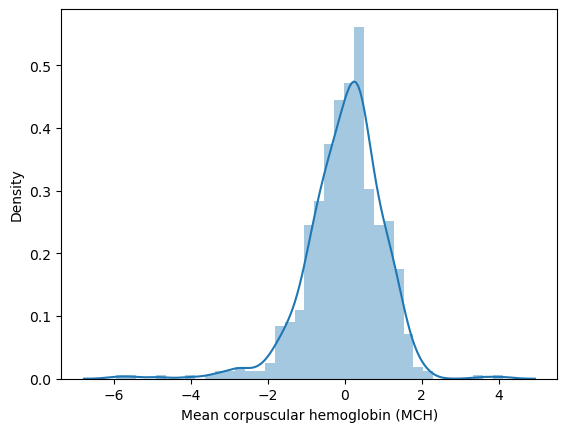

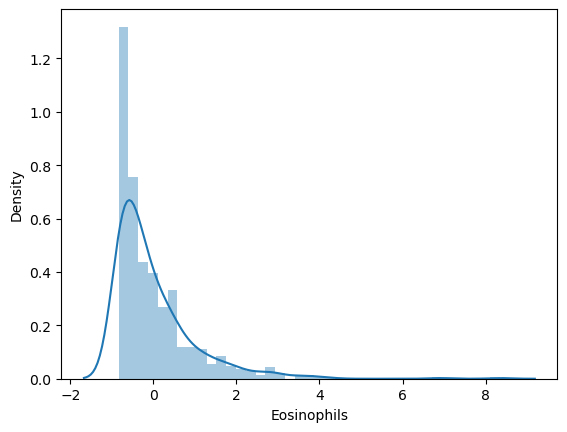

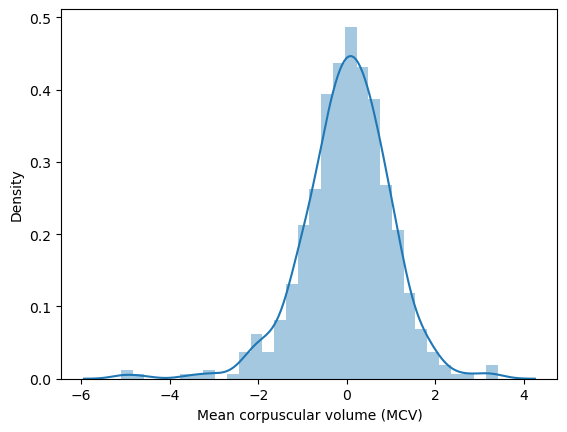

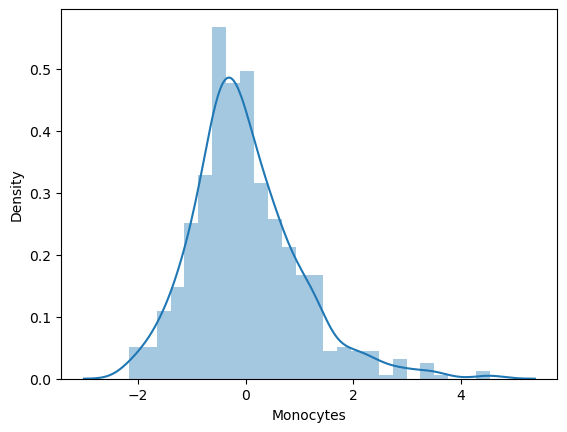

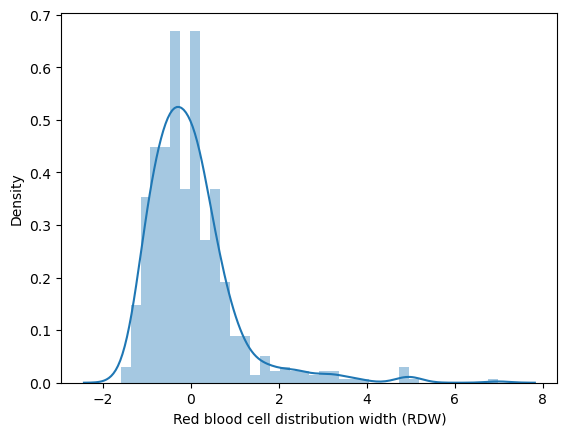

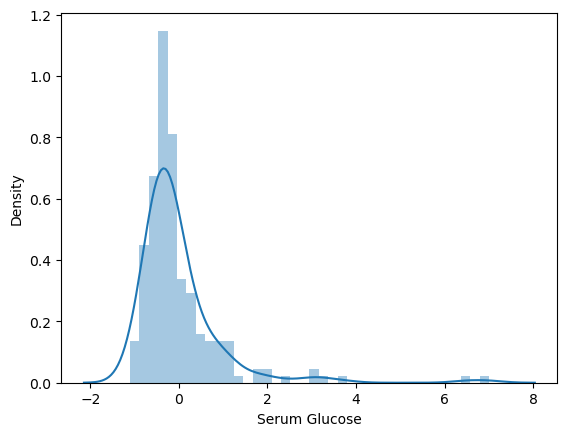

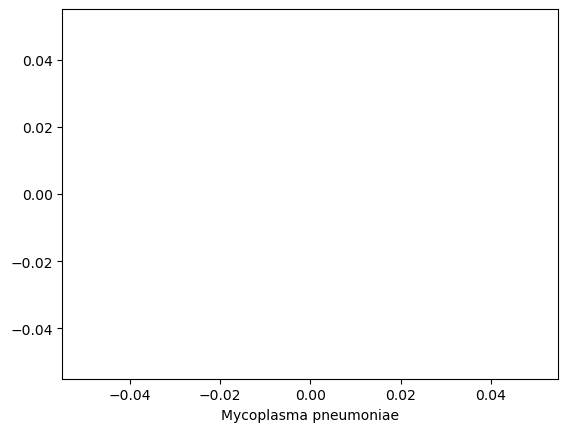

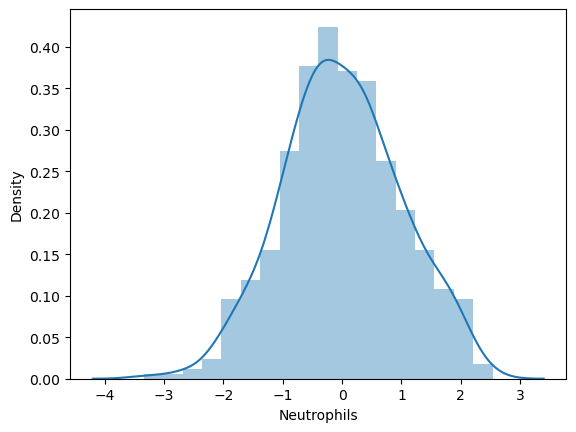

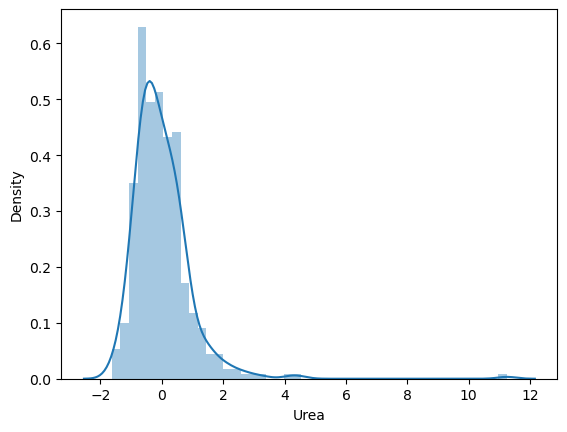

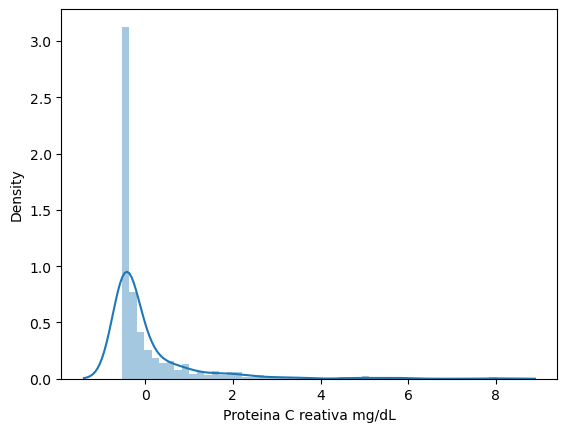

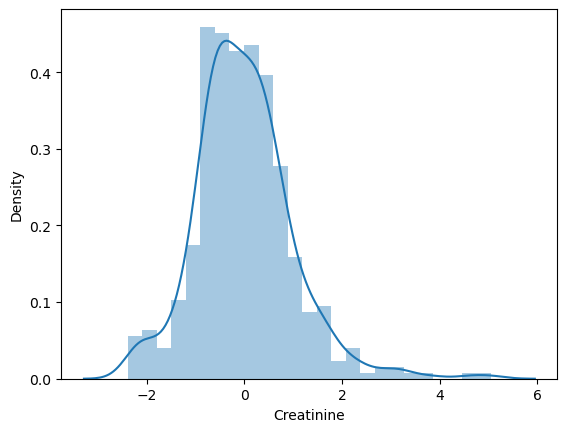

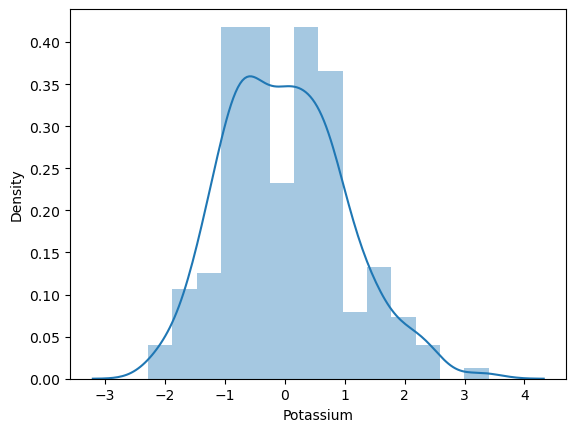

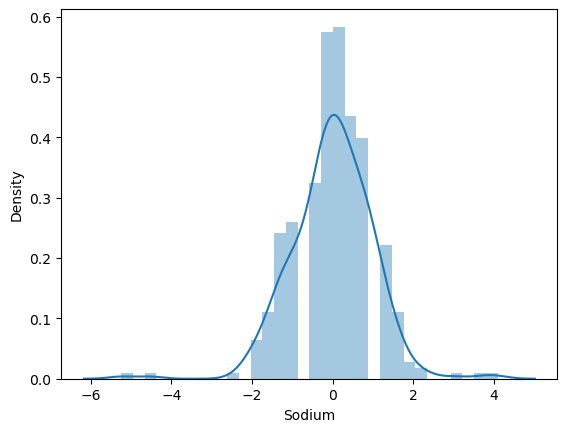

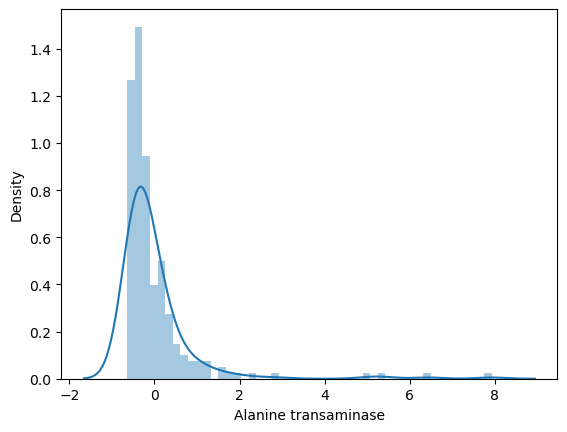

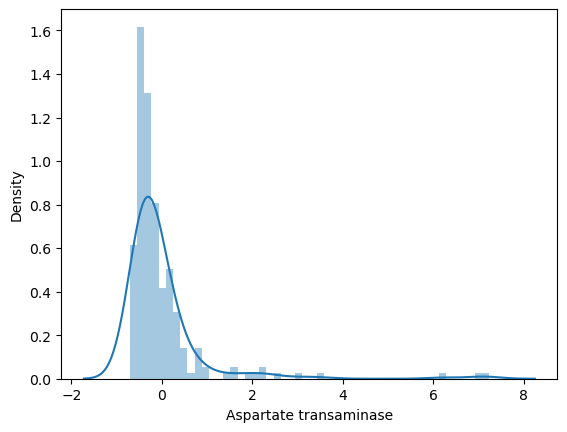

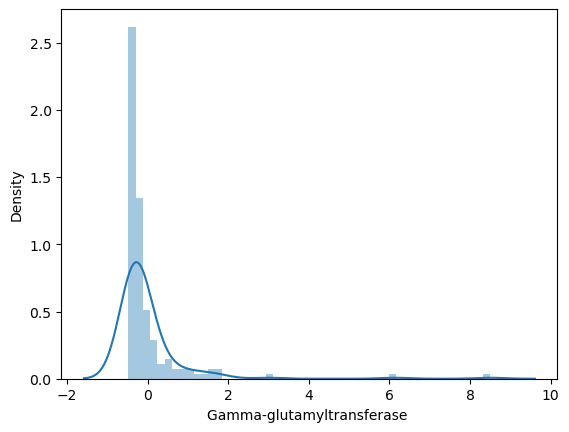

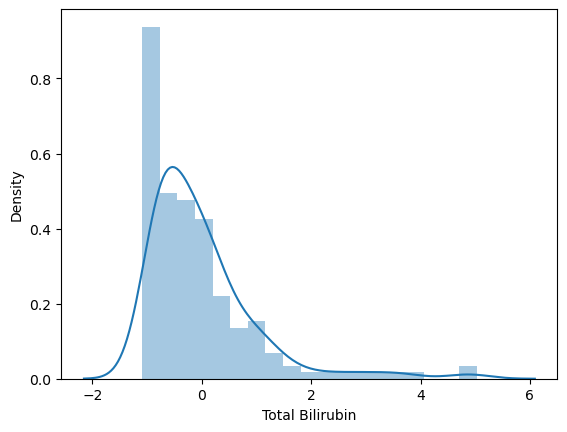

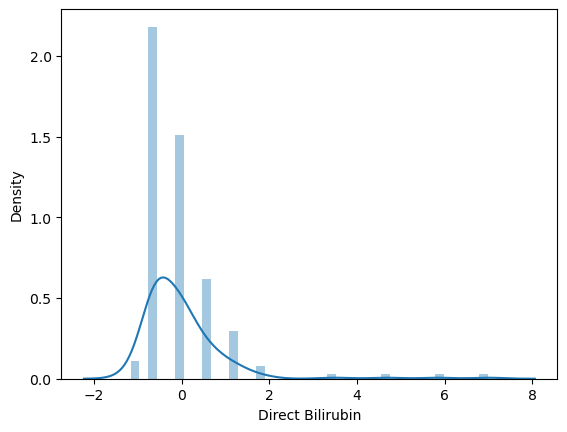

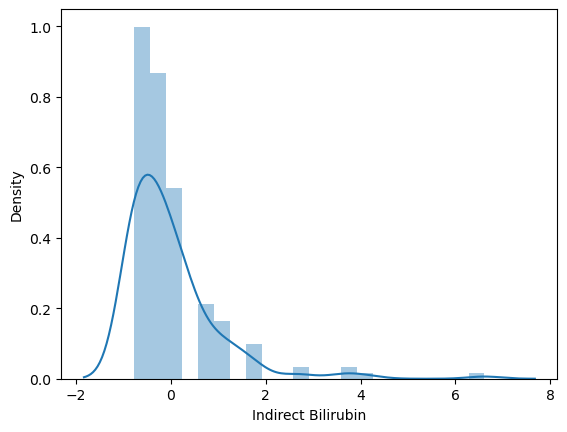

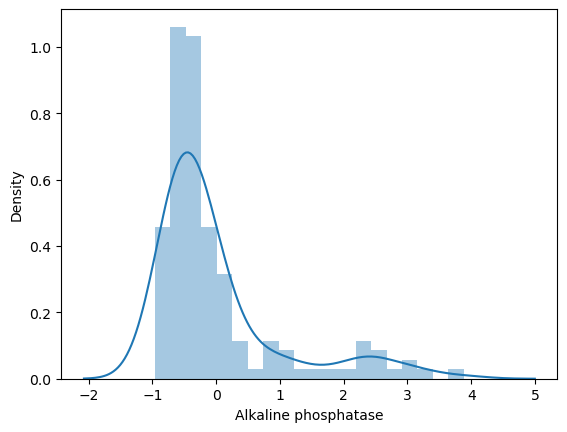

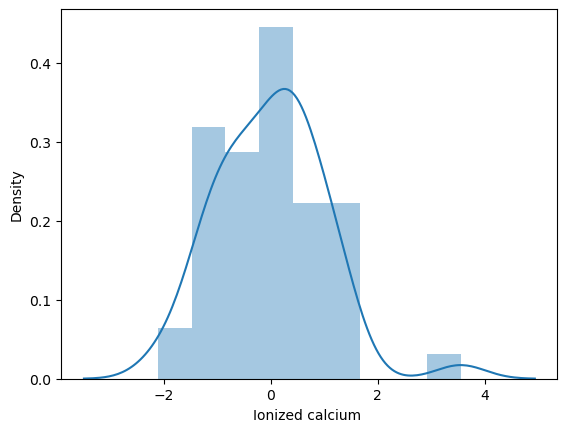

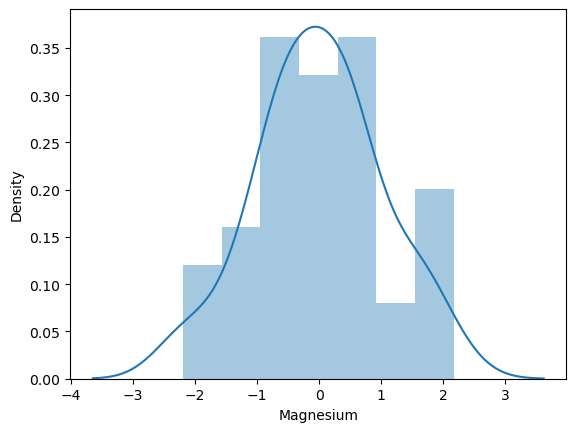

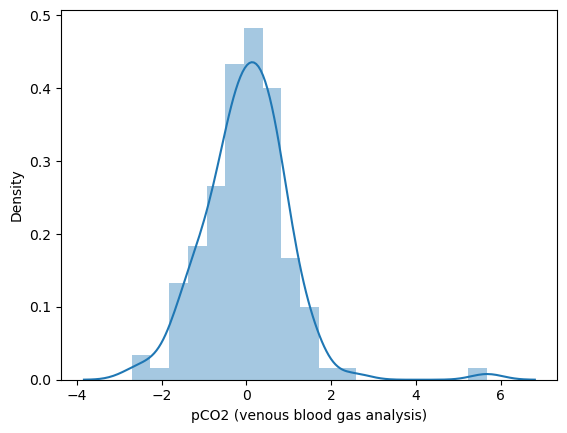

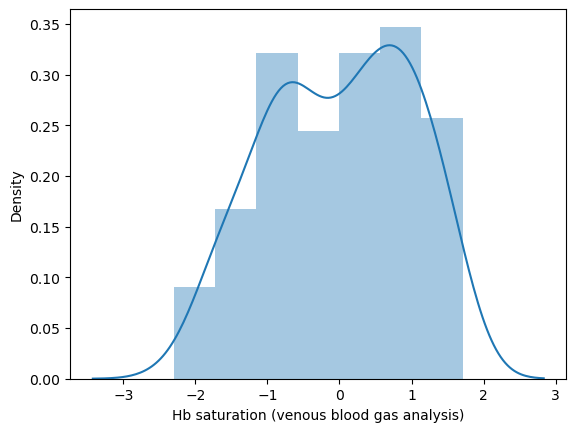

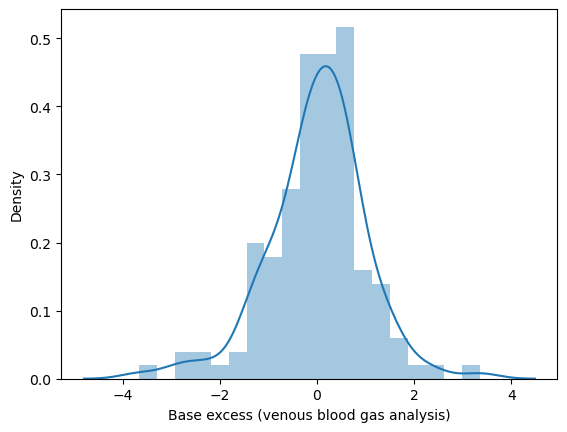

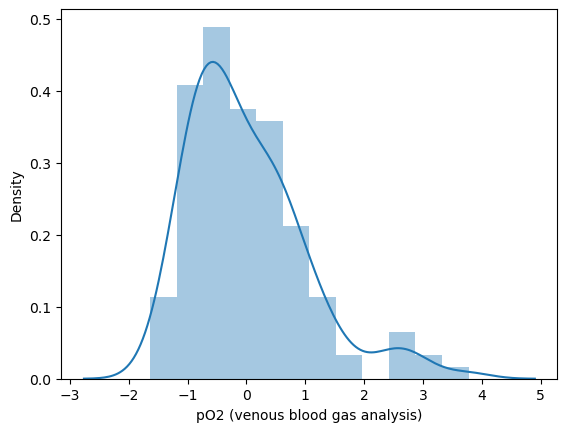

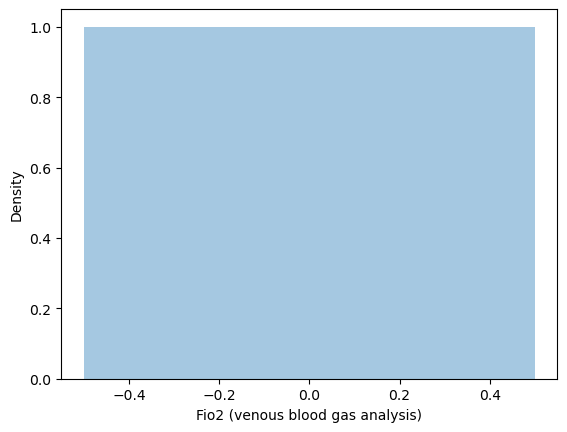

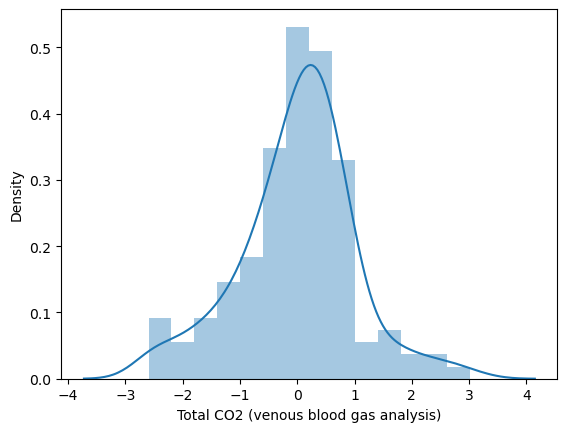

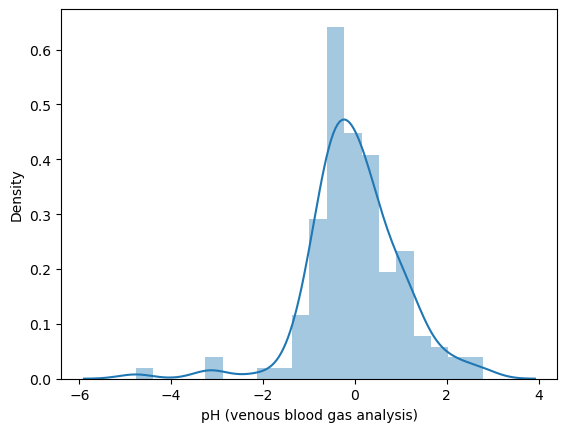

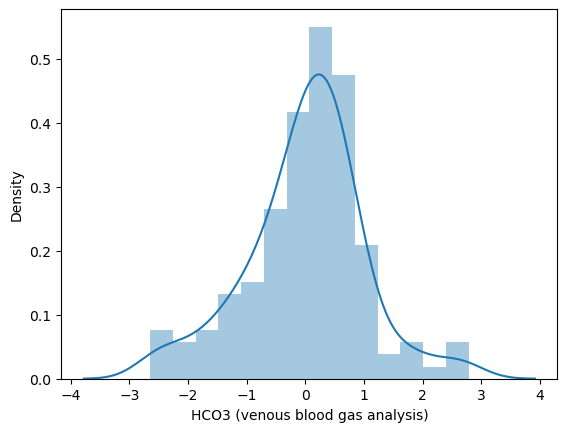

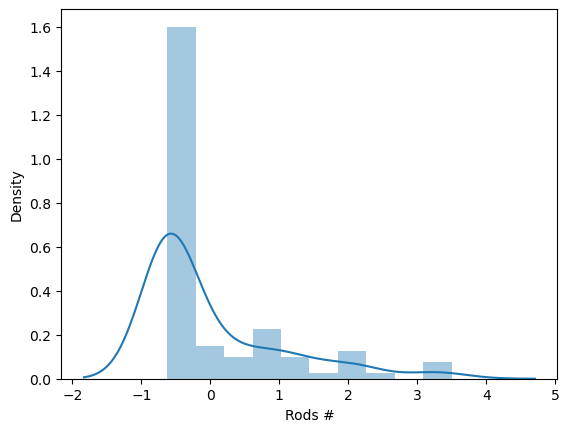

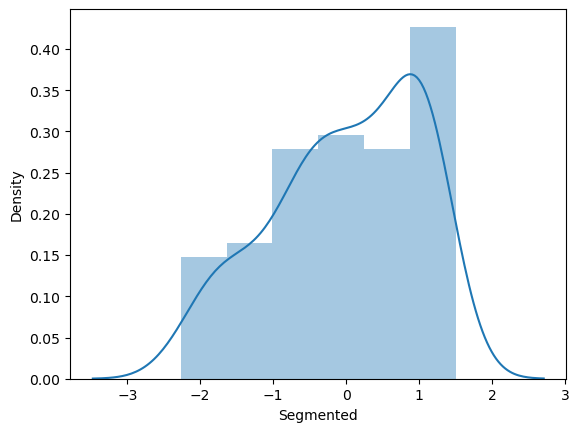

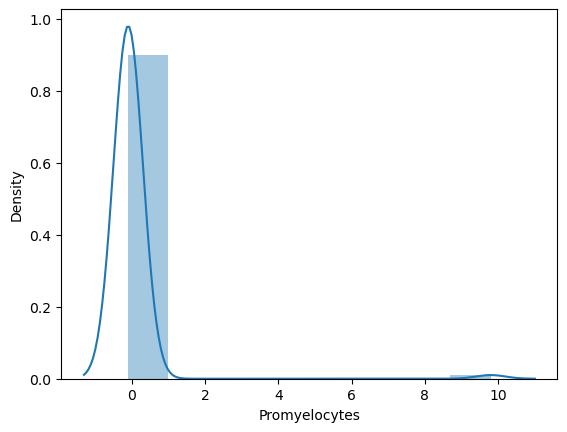

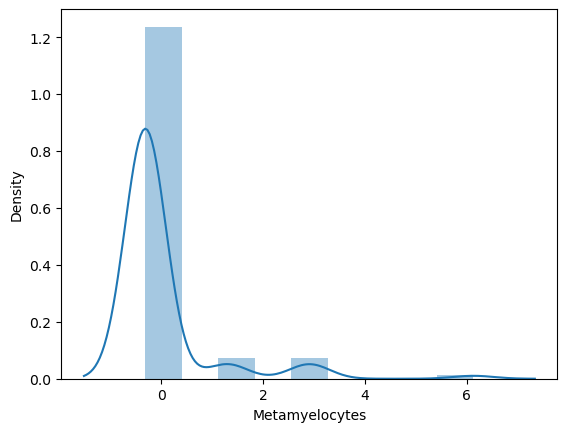

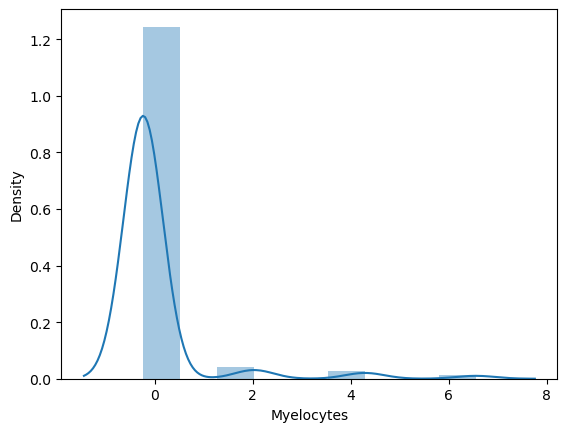

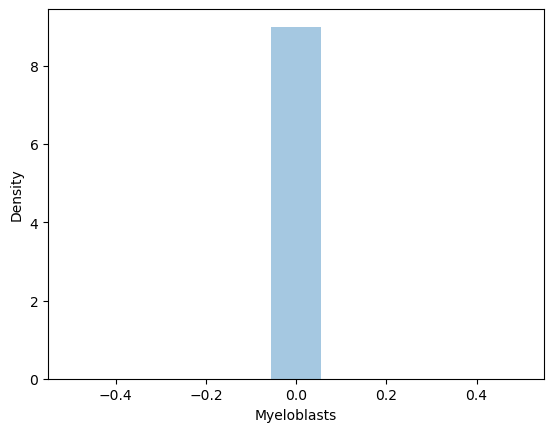

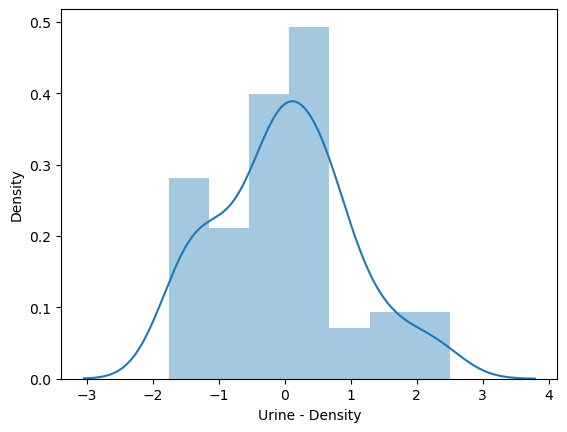

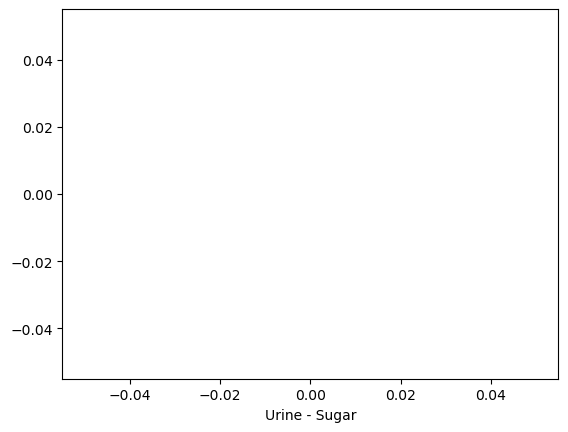

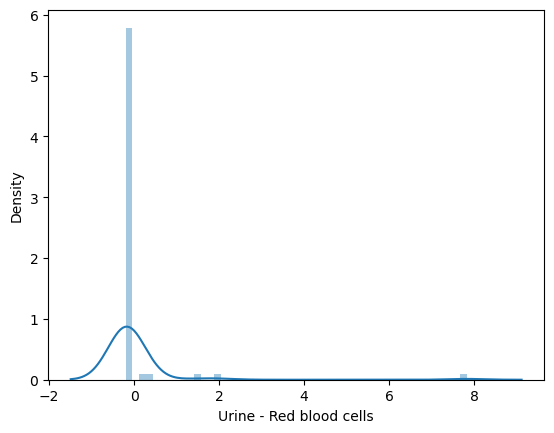

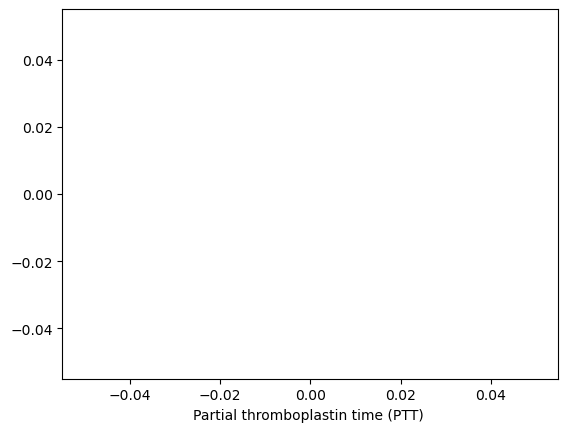

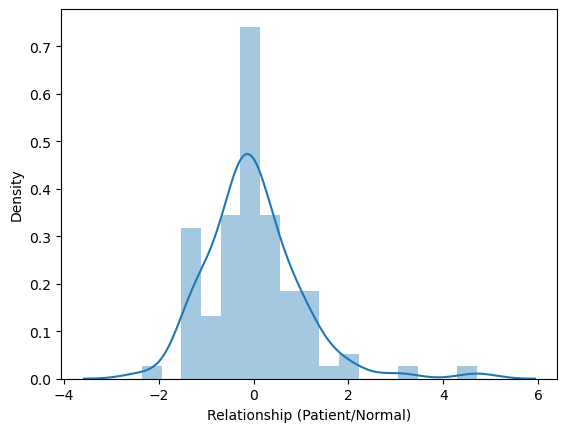

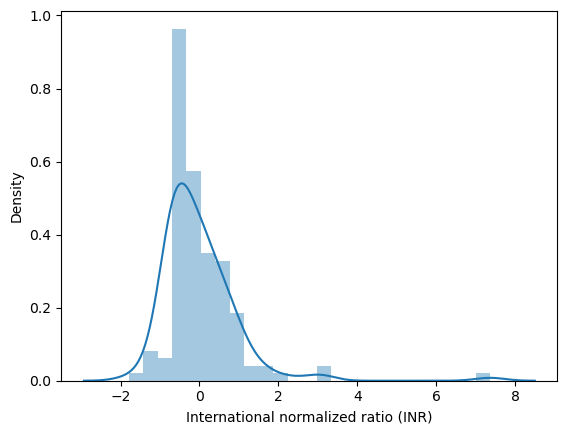

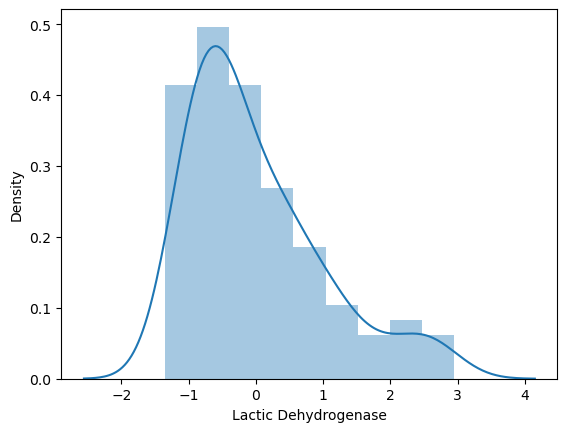

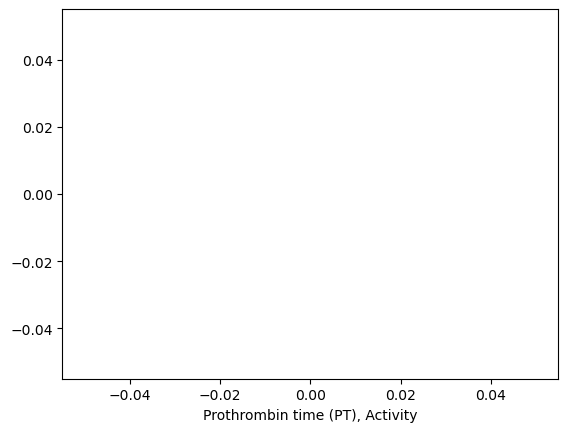

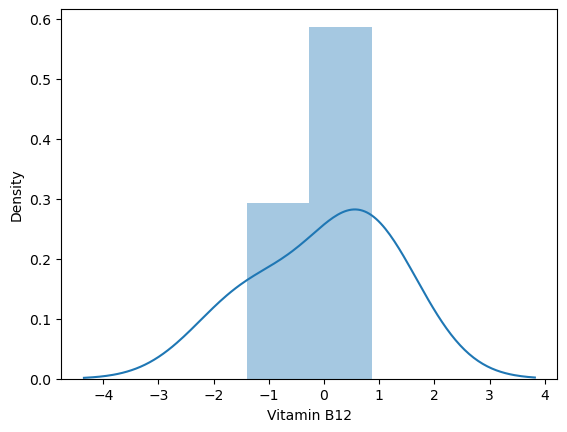

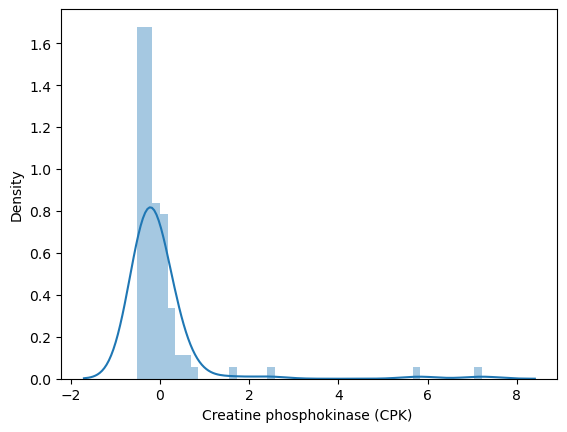

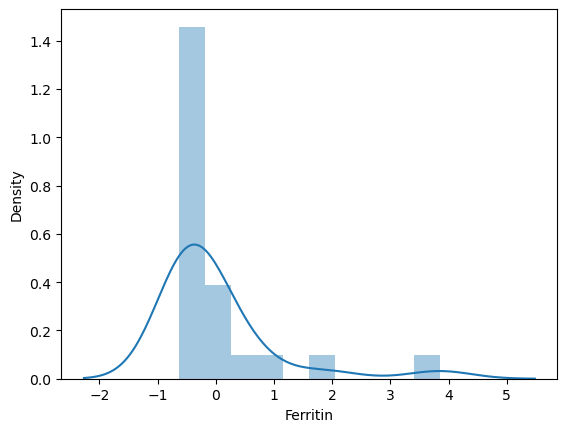

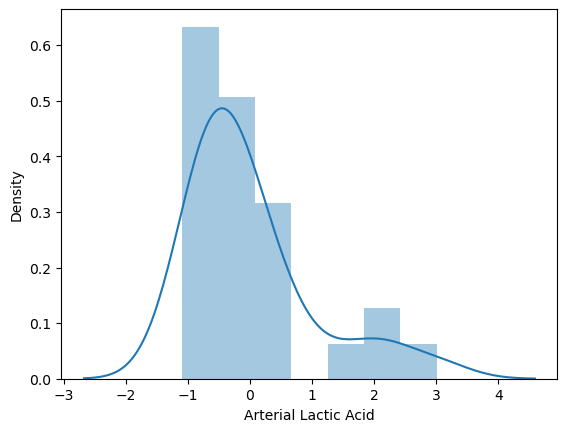

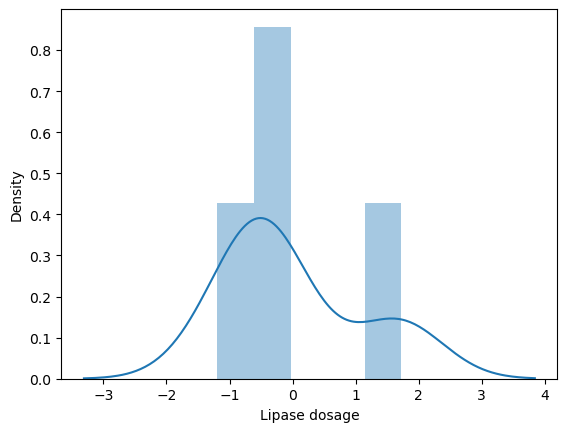

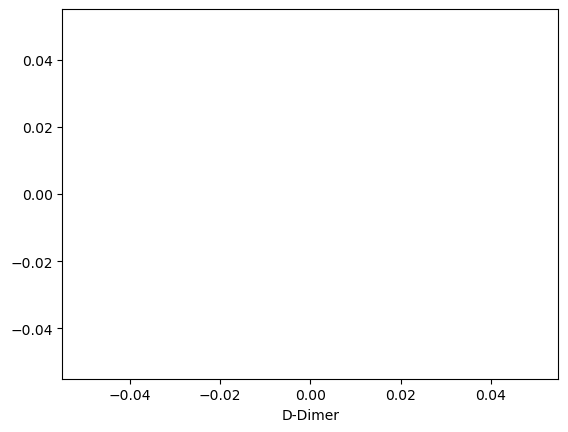

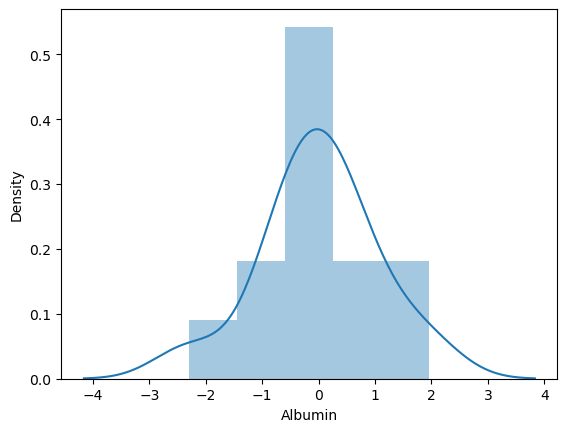

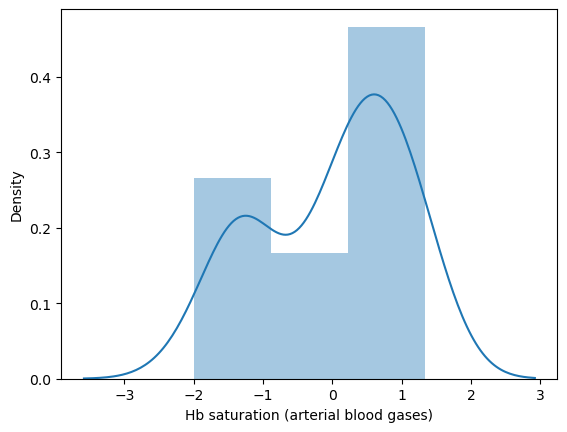

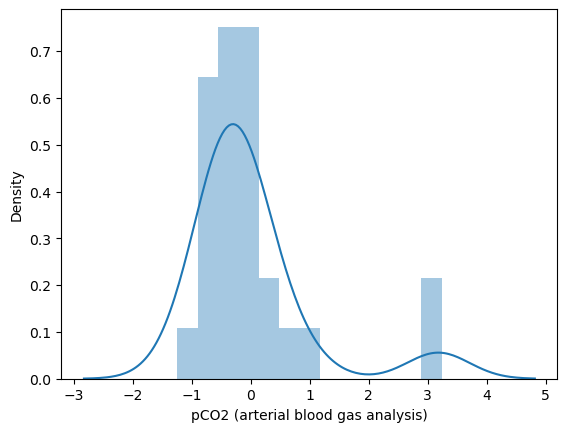

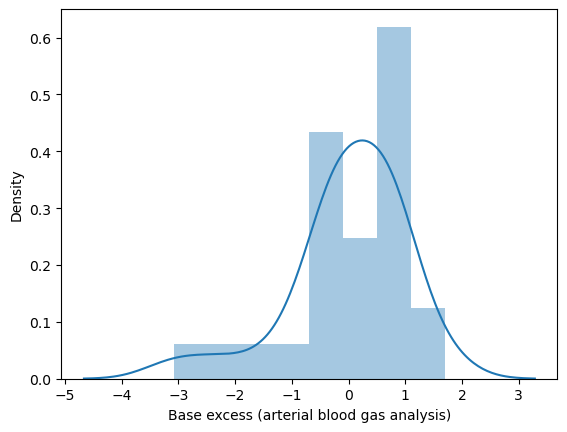

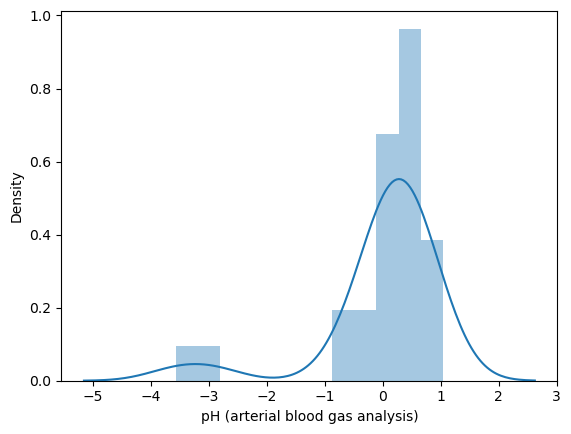

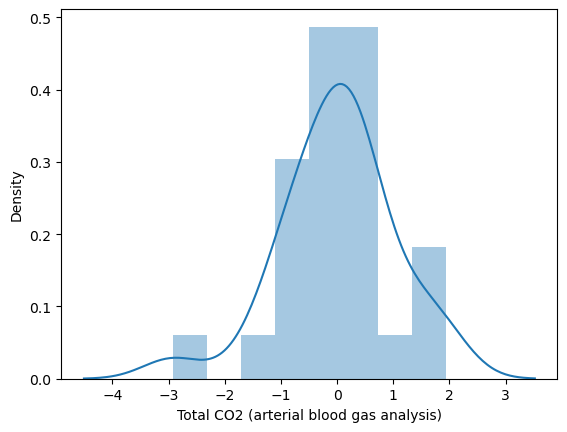

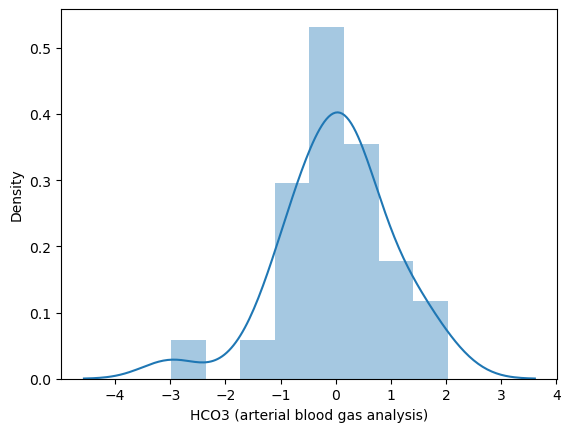

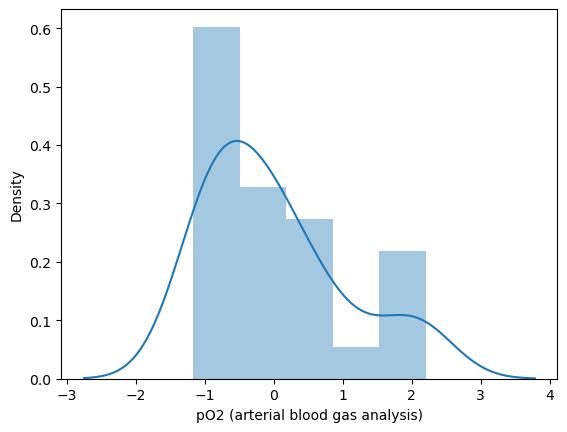

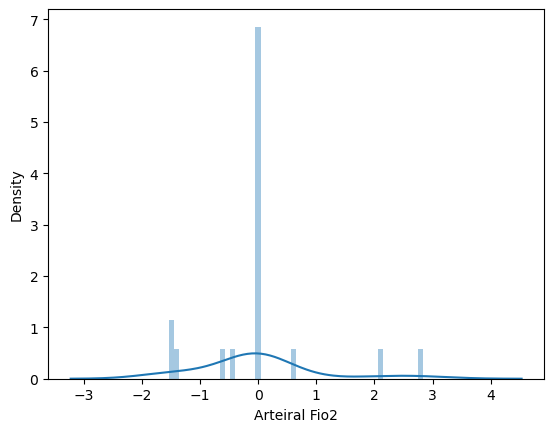

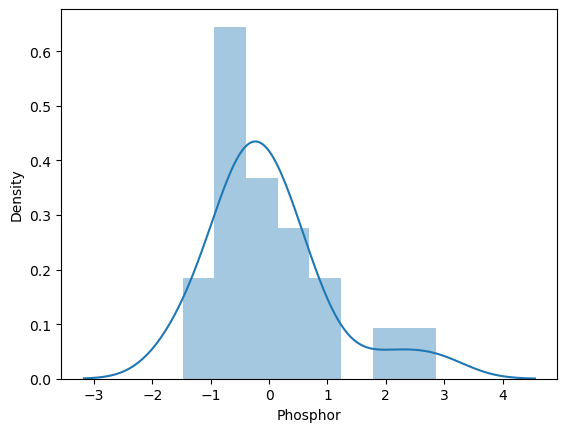

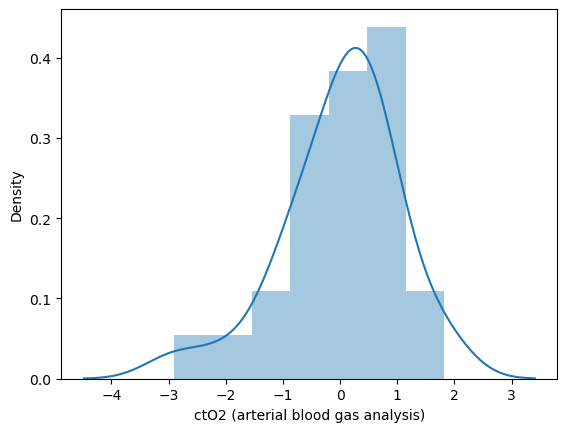

In [13]:
for col in df_all.select_dtypes('float'):
    plt.figure()
    sns.distplot(df_all[col])

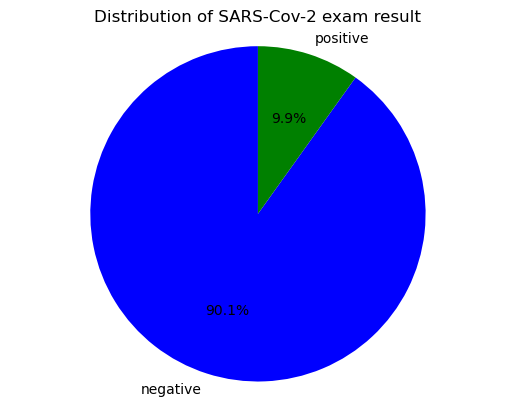

In [14]:
# calculate the distribution of the target column
target_dist = df_all['SARS-Cov-2 exam result'].value_counts()

# plot the pie chart with color
fig, ax = plt.subplots()
colors = ['blue', 'green']
ax.pie(target_dist.values, labels=target_dist.index, autopct='%1.1f%%', startangle=90, colors=colors)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of SARS-Cov-2 exam result')
plt.show()


# DATA PRE-PROCESSING

### Deleting Unnecessary Columns

In [15]:
# dropping the selected columns 
df = df_all.drop(["Patient ID", "Patient addmited to regular ward (1=yes, 0=no)",
                      "Patient addmited to semi-intensive unit (1=yes, 0=no)",
                      "Patient addmited to intensive care unit (1=yes, 0=no)"], axis=1)

### Handling Missing Values

In [16]:
# Function to plot a histogram that shows the number of NaN values for each column.
def plot_hist_nan(df):
    
    nan_df = pd.DataFrame(df.isna().sum().tolist(), df.columns.tolist()).reset_index()
    nan_df.columns = ['column_name', 'total_nan']
    nan_df['nan_perc'] = 100*round(nan_df['total_nan']/len(df),3)
    nan_df = nan_df.sort_values('total_nan', ascending=False)
    
    plt.figure(figsize=(30,20))
    step = 25
    j = 0
    t_plots = math.ceil(len(nan_df) / step)

    fig, axes = plt.subplots(t_plots, 1, figsize=(20,30))

    for i in range(0,len(nan_df), step):
        sns.barplot(x="nan_perc", y="column_name", data=nan_df[i:i+step], ax=axes[j])    
        axes[j].set_ylabel('Columns', fontsize = 15)
        axes[j].set_xlabel('NaN %', fontsize = 15)
        axes[j].set_xticks([0,10,20,30,40,50,60,70,80,90,100], minor=False)
        j = j + 1    
        if j == t_plots:
            break

<Figure size 3000x2000 with 0 Axes>

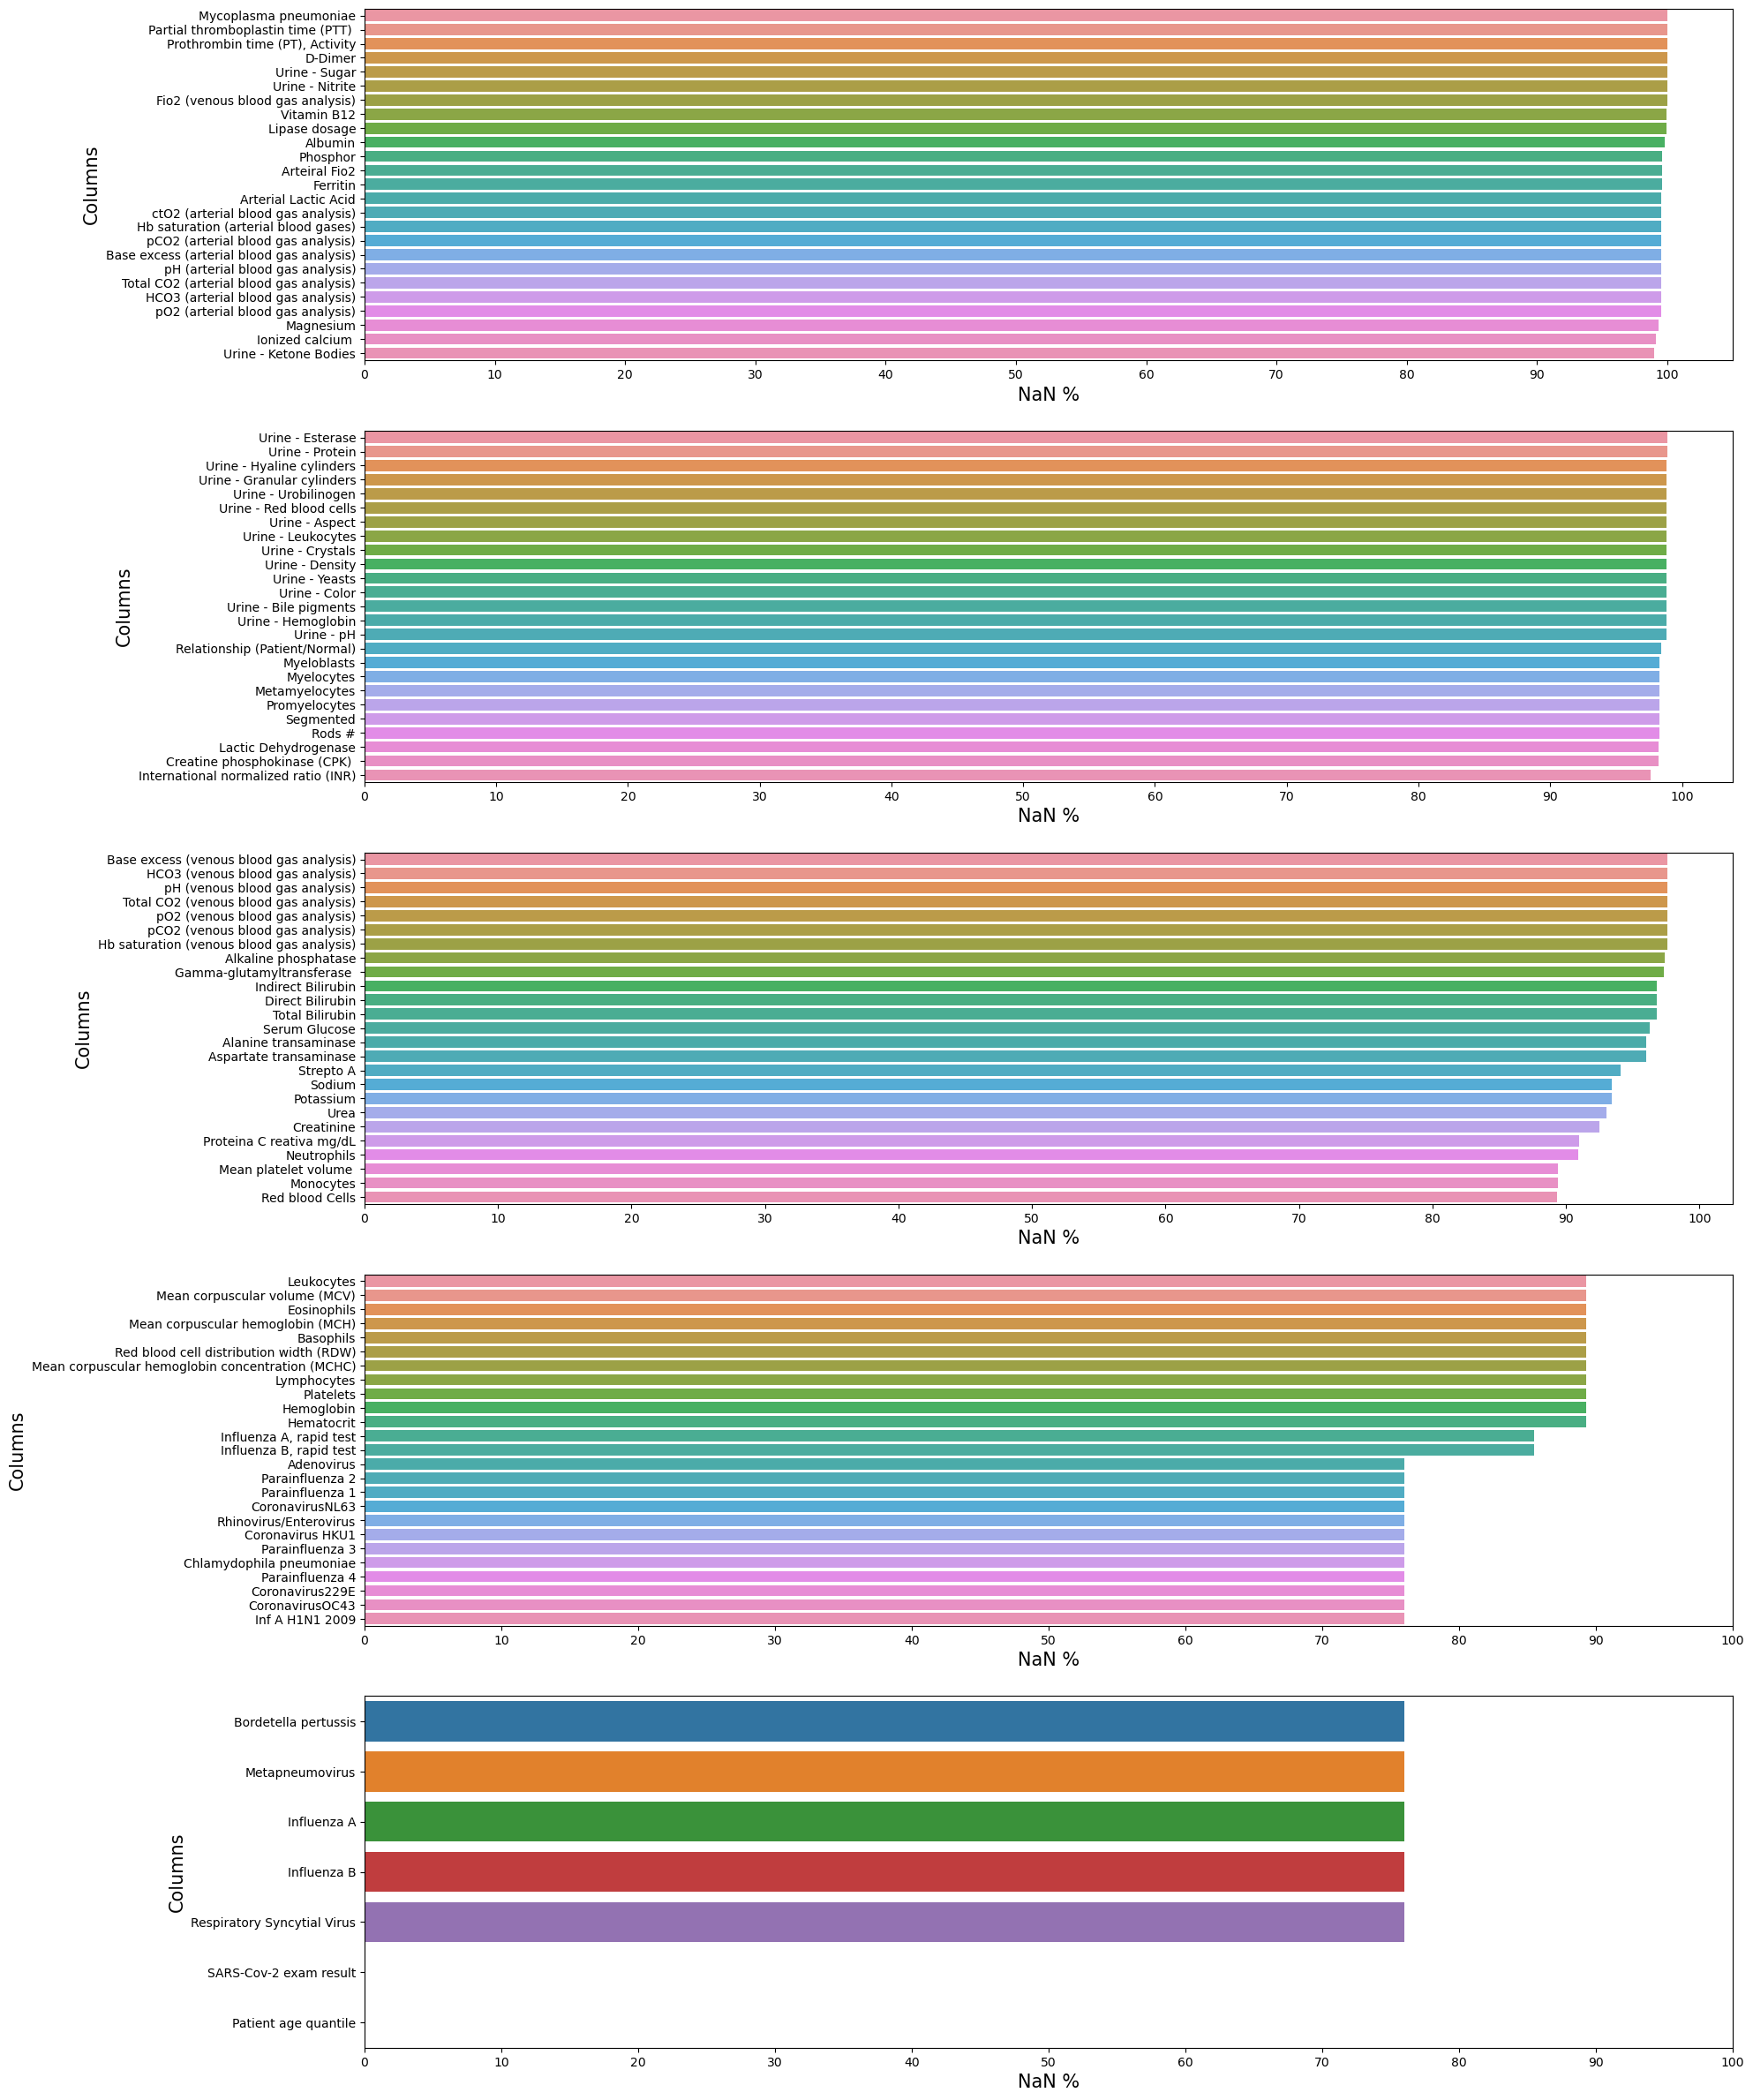

In [17]:
plot_hist_nan(df)

In [18]:
# It will be maintaned the features with less than 90% of the missing values.
df = df.loc[:, df.isnull().mean() <= .9]
print("The new dataset has {} rows and {} columns".format(df.shape[0], df.shape[1]))

The new dataset has 5644 rows and 35 columns


In [19]:
#replacing the rest of missing values with the mode of the corresponding columns
cols = df.columns
df = df.filter(cols).fillna(df.mode().iloc[0])

In [20]:
df

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test"
0,13,negative,-0.473031,-0.460932,-0.454604,-0.550290,-0.567950,-0.500423,-0.154166,-0.420197,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
1,17,negative,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
2,8,negative,-0.473031,-0.460932,-0.454604,-0.550290,-0.567950,-0.500423,-0.154166,-0.420197,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
3,5,negative,-0.473031,-0.460932,-0.454604,-0.550290,-0.567950,-0.500423,-0.154166,-0.420197,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
4,15,negative,-0.473031,-0.460932,-0.454604,-0.550290,-0.567950,-0.500423,-0.154166,-0.420197,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,3,positive,-0.473031,-0.460932,-0.454604,-0.550290,-0.567950,-0.500423,-0.154166,-0.420197,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
5640,17,negative,-0.473031,-0.460932,-0.454604,-0.550290,-0.567950,-0.500423,-0.154166,-0.420197,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
5641,4,negative,-0.473031,-0.460932,-0.454604,-0.550290,-0.567950,-0.500423,-0.154166,-0.420197,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
5642,10,negative,-0.473031,-0.460932,-0.454604,-0.550290,-0.567950,-0.500423,-0.154166,-0.420197,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative


## Filtering Data 

In [21]:
df = df.loc[((df_all['SARS-Cov-2 exam result'] == 'positive')
                         | (df_all['Hematocrit'].notnull())
                         | (df_all['Urine - Density'].notnull()))]

In [22]:
print("The new dataset has {} rows and {} columns".format(df.shape[0], df.shape[1]))

The new dataset has 1091 rows and 35 columns


In [23]:
# Function to plot a chart that shows the class distribution.
def plot_class_distribution(df: pd.DataFrame):
    
    values = df.groupby('SARS-Cov-2 exam result')['SARS-Cov-2 exam result'].count()
    n_samples = df.shape[0]
    
    plt.figure(figsize=(10,6))
    labels = ['Negative', 'Positive']
    explode = (0, 0.1)  # Slightly explode the 'Positive' slice for emphasis
    colors = ['green','orange']  # Changed colors: light green for 'Negative', light orange for 'Positive'

    plt.pie(values, colors=colors, autopct='%1.1f%%',
        startangle=90, pctdistance=0.85, explode=explode)

    plt.legend(labels, loc='best')  # Changed location to 'best' for automatic placement

    centre_circle = plt.Circle((0,0),0.70,fc='white')  # Adjusted the size for better fit
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)  
    plt.tight_layout()

    fig.text(0.5, 0.5, "{} samples".format(n_samples), ha='center', style='italic', fontsize=18)  # Centered text
    plt.show()


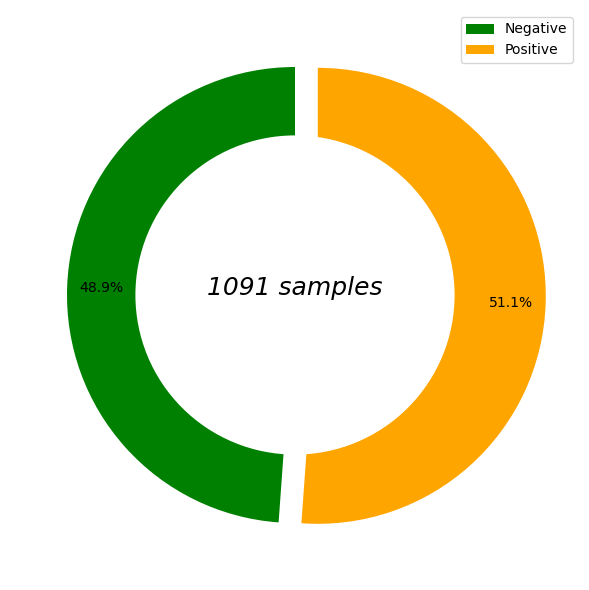

In [24]:
# Class distribution for the SARS-Cov-2 exam result
plot_class_distribution(df)

In [25]:
df

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test"
1,17,negative,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
8,1,negative,-1.571682,-0.774212,1.429667,-1.672222,-0.850035,-0.005738,3.331071,0.364550,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
15,9,negative,-0.747693,-0.586244,-0.429480,-0.213711,-1.361315,-1.114514,0.542882,-0.884923,...,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,negative,positive
18,11,negative,0.991838,0.792188,0.072992,-0.550290,0.542763,0.045436,-0.452899,-0.211488,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
22,9,negative,0.190738,-0.147652,-0.668155,1.020415,-0.127191,0.002791,-1.249524,-1.132592,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5633,4,positive,-0.473031,-0.460932,-0.454604,-0.550290,-0.567950,-0.500423,-0.154166,-0.420197,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
5634,15,positive,-0.473031,-0.460932,-0.454604,-0.550290,-0.567950,-0.500423,-0.154166,-0.420197,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
5639,3,positive,-0.473031,-0.460932,-0.454604,-0.550290,-0.567950,-0.500423,-0.154166,-0.420197,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative
5642,10,negative,-0.473031,-0.460932,-0.454604,-0.550290,-0.567950,-0.500423,-0.154166,-0.420197,...,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,negative,negative


### Encoding Categorical Features

In [26]:
df_numeric = df.copy()

le = LabelEncoder()

for col in df_numeric.select_dtypes(include=['object']):
    df_numeric[col] = le.fit_transform(df_numeric[col])

df_numeric = df_numeric.astype(int)

In [27]:
df_numeric

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,...,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,"Influenza B, rapid test","Influenza A, rapid test"
1,17,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,0,0,0
8,1,0,-1,0,1,-1,0,0,3,0,...,1,1,1,1,1,0,1,0,0,0
15,9,0,0,0,0,0,-1,-1,0,0,...,1,1,1,1,0,0,1,0,0,1
18,11,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,0,0,0
22,9,0,0,0,0,1,0,0,-1,-1,...,1,1,1,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5633,4,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,0,0,0
5634,15,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,0,0,0
5639,3,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,0,0,0
5642,10,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,1,0,0,0


# Min-Max scaling (Z-score normalization)

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
numeric_columns = ['Hemoglobin', 'Platelets']
scaler = MinMaxScaler()
df_all[numeric_columns] = scaler.fit_transform(df_all[numeric_columns])

In [30]:
df_all.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,0.616071,0.168399,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Column Transformers: 

In [31]:
numeric_columns = ['Hemoglobin', 'Platelets']
categorical_columns = ['Patient age quantile', 'Patient ID']

In [32]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

In [33]:
covid_processed = preprocessor.fit_transform(df_all)
covid_processed_df = pd.DataFrame(covid_processed)

In [34]:
covid_processed_df.head()

,0
0,"(0, 0)\tnan\n (0, 1)\tnan\n (0, 15)\t1.0\n..."
1,"(0, 0)\t-0.022340251998129397\n (0, 1)\t-0...."
2,"(0, 0)\tnan\n (0, 1)\tnan\n (0, 10)\t1.0\n..."
3,"(0, 0)\tnan\n (0, 1)\tnan\n (0, 7)\t1.0\n ..."
4,"(0, 0)\tnan\n (0, 1)\tnan\n (0, 17)\t1.0\n..."


# Hyperparameter Optimization

In [35]:
from sklearn.model_selection import train_test_split
X = df_numeric.loc[:, df_numeric.columns != 'SARS-Cov-2 exam result']
y = df_numeric['SARS-Cov-2 exam result']

# Split the dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the number of samples in each dataset
print("Number of samples in X_train: ", len(X_train))
print("Number of samples in y_train: ", len(y_train))
print("Number of samples in X_test: ", len(X_test))
print("Number of samples in y_test: ", len(y_test))


Number of samples in X_train:  872
Number of samples in y_train:  872
Number of samples in X_test:  219
Number of samples in y_test:  219


In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import numpy as np

# Assuming you have defined X_train, y_train, X_test, y_test

# Check unique values of y
unique_classes = np.unique(y_train)

# Ensure binary classification
if len(unique_classes) != 2:
    raise ValueError("Expected binary classification, but found {} classes in y_train".format(len(unique_classes)))

# Define the hyperparameters to search over for each model
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2]
}
rf_params = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7]
}
lr_params = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
dt_params = {
    'max_depth': [3, 5, 7, 10],
    'criterion': ['gini', 'entropy']
}
knn_params = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Define the models to evaluate
models = {
    'XGBoost': (XGBClassifier(), xgb_params),
    'RF': (RandomForestClassifier(), rf_params),
    'LR': (LogisticRegression(), lr_params),
    'DT': (DecisionTreeClassifier(), dt_params),
    'KNN': (KNeighborsClassifier(), knn_params)
}

# Perform grid search for each model
for model_alias in models:
    print("Model: {}\n".format(model_alias))
    model, params = models[model_alias]
    clf = GridSearchCV(model, params, cv=5)
    clf.fit(X_train, y_train)
    print("Best parameters found: ", clf.best_params_)
    print("Best score: ", clf.best_score_)
    print("_______________________________________________________________________________\n")


Model: XGBoost

Best parameters found:  {'learning_rate': 0.05, 'n_estimators': 100}
Best score:  0.9128275862068966
_______________________________________________________________________________

Model: RF

Best parameters found:  {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 50}
Best score:  0.9128210180623973
_______________________________________________________________________________

Model: LR

Best parameters found:  {'C': 10.0, 'solver': 'newton-cg'}
Best score:  0.8910279146141216
_______________________________________________________________________________

Model: DT

Best parameters found:  {'criterion': 'entropy', 'max_depth': 5}
Best score:  0.9082430213464697
_______________________________________________________________________________

Model: KNN

Best parameters found:  {'algorithm': 'kd_tree', 'n_neighbors': 3, 'weights': 'uniform'}
Best score:  0.8692610837438425
_______________________________________________________________________________



# Linear Regression

In [37]:
# ... (Your code for XGBoost, Decision Tree, etc.)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

from   sklearn.metrics       import mean_squared_error, mean_absolute_error,r2_score;

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

threshold = 0.5  # Define a threshold for prediction errors
y_pred_class = np.where(y_pred_lin >= threshold, 1, 0)  # Convert predictions to binary classes based on threshold
accuracy_lin = accuracy_score(y_test, y_pred_class)

print('--- Linear Regression ---', '\n',
      'Mean Squared Error:', mse_lin, '\n',
      'R-squared:', r2_lin, '\n',
      'Accuracy:', accuracy_lin)


--- Linear Regression --- 
 Mean Squared Error: 0.128887357439831 
 R-squared: 0.48443982066958 
 Accuracy: 0.8995433789954338


## Train-Test

In [38]:
X = df_numeric.loc[:, df_numeric.columns != 'SARS-Cov-2 exam result']
y = df_numeric['SARS-Cov-2 exam result']

# assigning the splitting of data into respective variables
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


In [39]:

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score



In [40]:
accuracy_lst = []
auc_lst = []

def model_assess(model, name='Default'):
    model.fit(X_train, y_train)
    prds = model.predict(X_test)
    model_acc = accuracy_score(y_test, prds)
    accuracy_lst.append(100*model_acc)
    
    # Calculate AUC
    probas = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probas)
    auc_lst.append(auc)
    
    print('---', name, '---', '\n',
          confusion_matrix(y_test, prds), '\n',
          'Accuracy:', (accuracy_score(y_test, prds)), '\n',
          'Classification Report:', (classification_report(y_test, prds)),
          'AUC:', auc)
    print('--------------------------------------------------------------------------------')


In [41]:
# Logistic Regression
lg = LogisticRegression(C=10.0, solver='newton-cg')
model_assess(lg, 'Logistic Regression')




--- Logistic Regression --- 
 [[ 96  11]
 [ 11 101]] 
 Accuracy: 0.8995433789954338 
 Classification Report:               precision    recall  f1-score   support

           0       0.90      0.90      0.90       107
           1       0.90      0.90      0.90       112

    accuracy                           0.90       219
   macro avg       0.90      0.90      0.90       219
weighted avg       0.90      0.90      0.90       219
 AUC: 0.9440086782376502
--------------------------------------------------------------------------------


In [42]:
# Decision Tree
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5)
model_assess(tree, 'Decision Trees')

--- Decision Trees --- 
 [[102   5]
 [ 11 101]] 
 Accuracy: 0.9269406392694064 
 Classification Report:               precision    recall  f1-score   support

           0       0.90      0.95      0.93       107
           1       0.95      0.90      0.93       112

    accuracy                           0.93       219
   macro avg       0.93      0.93      0.93       219
weighted avg       0.93      0.93      0.93       219
 AUC: 0.9488901869158879
--------------------------------------------------------------------------------


In [43]:
# Random Forest
rforest = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=7)
model_assess(rforest, 'Random Forest')


--- Random Forest --- 
 [[101   6]
 [ 11 101]] 
 Accuracy: 0.9223744292237442 
 Classification Report:               precision    recall  f1-score   support

           0       0.90      0.94      0.92       107
           1       0.94      0.90      0.92       112

    accuracy                           0.92       219
   macro avg       0.92      0.92      0.92       219
weighted avg       0.92      0.92      0.92       219
 AUC: 0.9702102803738317
--------------------------------------------------------------------------------


In [44]:
# knn
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='kd_tree')
model_assess(knn, name='KNN')


--- KNN --- 
 [[ 92  15]
 [ 11 101]] 
 Accuracy: 0.8812785388127854 
 Classification Report:               precision    recall  f1-score   support

           0       0.89      0.86      0.88       107
           1       0.87      0.90      0.89       112

    accuracy                           0.88       219
   macro avg       0.88      0.88      0.88       219
weighted avg       0.88      0.88      0.88       219
 AUC: 0.9140937917222964
--------------------------------------------------------------------------------


# XGBoost using Pipeline

In [45]:
# XGBoost
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create a standardization step
scaler = StandardScaler()

# Create the XGBoost classifier
xgb = XGBClassifier(n_estimators=100, learning_rate=0.05)

# Combine steps into a pipeline
pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('xgb', xgb)
])

# Call your model assessment function with the pipeline
model_assess(pipeline, 'XGBoost Pipeline')

--- XGBoost Pipeline --- 
 [[102   5]
 [ 11 101]] 
 Accuracy: 0.9269406392694064 
 Classification Report:               precision    recall  f1-score   support

           0       0.90      0.95      0.93       107
           1       0.95      0.90      0.93       112

    accuracy                           0.93       219
   macro avg       0.93      0.93      0.93       219
weighted avg       0.93      0.93      0.93       219
 AUC: 0.9693758344459279
--------------------------------------------------------------------------------
